# SarXarray Demo Notebook

In this Jupyter Notebook, we demonstrate the following operations using `sarxarray`:

- Load an SLC stack in binary format into a `xarray.Dataset` object;
- Append lat and lon coordinates;
- Create an MRM of a subset of the SLC stack;
- Apply point selection to a subset of the SLC stack;
- Export the selection results in Zarr format

### Data used for this Notebook
The data needed for this Notebook is stored in the following path on Spider: `/project/caroline/Public/demo_sarxarray/data/nl_veenweiden_s1_asc_t088/`.

### Setup environment
For the python environment setup, we assume you already started an independent Python environment with Python version later than 3.10

To execute this notebook, fiest clone the `sarxarray` repostory to your local:

```sh
git clone git@github.com:MotionbyLearning/sarxarray.git
```

Then get into the repository directory:
```sh
cd sarxarray
```

Some extra python dependencies are required to execute this notebook. You can install the extra python dependencies by:
```sh
pip install .[demo]
```

After installation, execute the notebook in a JupyterLab session, which can be started by running `jupyterlab` command in your command line:

```bash
jupyter-lab
```

A new tab will be opened in your default browser to execute this notebook.

### Load a interferogram stack

In [9]:
import numpy as np
from pathlib import Path
import sarxarray

We will load a interferogram stack, which has been corregistered and saved as binary files. In this example we will demo 3 interferograms with a `(azimuth, range)` coverage of `(9914, 41174)`. We assume the shape and data type is known.

In [10]:
# Path to the stack
path = Path('../../data/nl_veenweiden_s1_asc_t088/')

# Metadata of the stack
shape=(9914, 41174)
dtype = np.dtype([('re', np.float32), ('im', np.float32)])

# Set a customizechunk size
chunks=(500, 500)

In [11]:
# Make a list of SLCs to read
f_slc = 'slc_srd_nl_veenweiden.raw' 
list_slcs = [p/f_slc for p in path.rglob("????????")]
list_slcs

[PosixPath('../../data/nl_veenweiden_s1_asc_t088/20210407/slc_srd_nl_veenweiden.raw'),
 PosixPath('../../data/nl_veenweiden_s1_asc_t088/20210413/slc_srd_nl_veenweiden.raw'),
 PosixPath('../../data/nl_veenweiden_s1_asc_t088/20210419/slc_srd_nl_veenweiden.raw')]

Now we perform a lazy loading of the stack

In [12]:
stack = sarxarray.from_binary(list_slcs, shape, dtype=dtype, chunks=chunks)
stack

<xarray.Dataset>
Dimensions:    (azimuth: 9914, range: 41174, time: 3)
Coordinates:
  * azimuth    (azimuth) int64 0 1 2 3 4 5 6 ... 9908 9909 9910 9911 9912 9913
  * range      (range) int64 0 1 2 3 4 5 ... 41168 41169 41170 41171 41172 41173
  * time       (time) int64 0 1 2
Data variables:
    complex    (azimuth, range, time) complex64 dask.array<chunksize=(500, 500, 1), meta=np.ndarray>
    amplitude  (azimuth, range, time) float32 dask.array<chunksize=(500, 500, 1), meta=np.ndarray>
    phase      (azimuth, range, time) float32 dask.array<chunksize=(500, 500, 1), meta=np.ndarray>

The data variable of the stack will be a `Dask.array`. For example we can take a look of `complex`, which is the complex value of the interferograms:

In [13]:
stack.complex

<xarray.DataArray 'complex' (azimuth: 9914, range: 41174, time: 3)>
dask.array<transpose, shape=(9914, 41174, 3), dtype=complex64, chunksize=(500, 500, 1), chunktype=numpy.ndarray>
Coordinates:
  * azimuth  (azimuth) int64 0 1 2 3 4 5 6 ... 9908 9909 9910 9911 9912 9913
  * range    (range) int64 0 1 2 3 4 5 6 ... 41168 41169 41170 41171 41172 41173
  * time     (time) int64 0 1 2

### Append georeferenced coordinates as new data fields

The `sarxarray` is implemented as an extension of `Xarray.Dataset`, which means we can modify the `stack` variable as a normal `Dataset` objet. For example, we can load in the georeference coordinates (lattitude and longitude) also with `from_binary`, and attach them to `stack`.

In [14]:
# Geo referenced coordinates
f_lat = [path/'phi_nl_veenweiden.raw']
f_lon = [path/'lam_nl_veenweiden.raw']

In [15]:
# Load coordinates and assign them to stack
lat = sarxarray.from_binary(f_lat, shape, vlabel="lat", dtype=np.float32, chunks=chunks)
lon = sarxarray.from_binary(f_lon, shape, vlabel="lon", dtype=np.float32, chunks=chunks)
stack = stack.assign_coords(lat = (("azimuth", "range"), lat.squeeze().lat.data), lon = (("azimuth", "range"), lon.squeeze().lon.data))
stack

<xarray.Dataset>
Dimensions:    (azimuth: 9914, range: 41174, time: 3)
Coordinates:
  * azimuth    (azimuth) int64 0 1 2 3 4 5 6 ... 9908 9909 9910 9911 9912 9913
  * range      (range) int64 0 1 2 3 4 5 ... 41168 41169 41170 41171 41172 41173
  * time       (time) int64 0 1 2
    lat        (azimuth, range) float32 dask.array<chunksize=(500, 500), meta=np.ndarray>
    lon        (azimuth, range) float32 dask.array<chunksize=(500, 500), meta=np.ndarray>
Data variables:
    complex    (azimuth, range, time) complex64 dask.array<chunksize=(500, 500, 1), meta=np.ndarray>
    amplitude  (azimuth, range, time) float32 dask.array<chunksize=(500, 500, 1), meta=np.ndarray>
    phase      (azimuth, range, time) float32 dask.array<chunksize=(500, 500, 1), meta=np.ndarray>

### Create MRM of a subset
We will compute a Mean Reflection Map (MRM) using a subset of the stack.

In [16]:
mrm = stack.slcstack.mrm()
mrm

<xarray.DataArray 'amplitude' (azimuth: 9914, range: 41174)>
dask.array<mean_agg-aggregate, shape=(9914, 41174), dtype=float32, chunksize=(500, 500), chunktype=numpy.ndarray>
Coordinates:
  * azimuth  (azimuth) int64 0 1 2 3 4 5 6 ... 9908 9909 9910 9911 9912 9913
  * range    (range) int64 0 1 2 3 4 5 6 ... 41168 41169 41170 41171 41172 41173
    lat      (azimuth, range) float32 dask.array<chunksize=(500, 500), meta=np.ndarray>
    lon      (azimuth, range) float32 dask.array<chunksize=(500, 500), meta=np.ndarray>

In [17]:
# Compute a subset of the mrm
mrm_subset = mrm[5000:5500, 10000:10500]
mrm_subset = mrm_subset.compute()

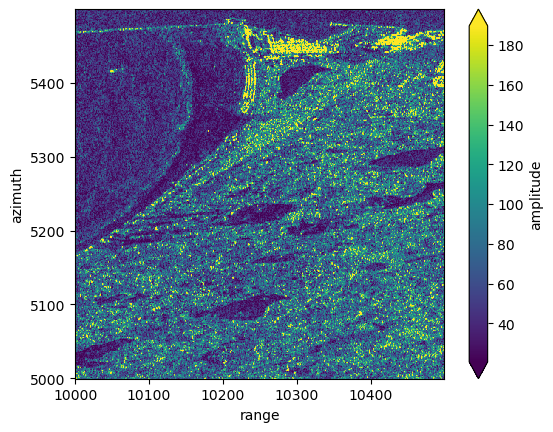

In [18]:
# Visualize
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
ax.imshow(mrm_subset)
mrm_subset.plot(robust=True, ax=ax)

### Export to a Space Time Matrix
To prepare the data for PSI processing, we can select temporal consistant pixels, and transform them into a Space-Time Matrix. This can be done using the `point_selection` function

In [19]:
# Select a subset
stack_subset = stack.sel(azimuth=range(6000,6500), range=range(11000,11500))

# Perform point selection
stm = stack_subset.slcstack.point_selection(threshold=2, method="amplitude_dispersion")
stm

<xarray.Dataset>
Dimensions:    (time: 3, points: 141269)
Coordinates:
  * time       (time) int64 0 1 2
    lat        (points) float32 dask.array<chunksize=(1000,), meta=np.ndarray>
    lon        (points) float32 dask.array<chunksize=(1000,), meta=np.ndarray>
  * points     (points) int64 0 1 2 3 4 5 ... 141264 141265 141266 141267 141268
    azimuth    (points) int64 dask.array<chunksize=(1000,), meta=np.ndarray>
    range      (points) int64 dask.array<chunksize=(1000,), meta=np.ndarray>
Data variables:
    complex    (points, time) complex64 dask.array<chunksize=(1000, 3), meta=np.ndarray>
    amplitude  (points, time) float32 dask.array<chunksize=(1000, 3), meta=np.ndarray>
    phase      (points, time) float32 dask.array<chunksize=(1000, 3), meta=np.ndarray>

The selected points can be saved to a `Zarr` storage

In [21]:
# Export to Zarr
stm.to_zarr("stm.zarr", mode="w")

And can be read by `xr.open_zarr`

In [22]:
# Load exported STM in Zarr
import xarray as xr
stm_read = xr.open_zarr("stm.zarr")
stm_read

<xarray.Dataset>
Dimensions:    (points: 141269, time: 3)
Coordinates:
    azimuth    (points) int64 dask.array<chunksize=(1000,), meta=np.ndarray>
    lat        (points) float32 dask.array<chunksize=(1000,), meta=np.ndarray>
    lon        (points) float32 dask.array<chunksize=(1000,), meta=np.ndarray>
  * points     (points) int64 0 1 2 3 4 5 ... 141264 141265 141266 141267 141268
    range      (points) int64 dask.array<chunksize=(1000,), meta=np.ndarray>
  * time       (time) int64 0 1 2
Data variables:
    amplitude  (points, time) float32 dask.array<chunksize=(1000, 3), meta=np.ndarray>
    complex    (points, time) complex64 dask.array<chunksize=(1000, 3), meta=np.ndarray>
    phase      (points, time) float32 dask.array<chunksize=(1000, 3), meta=np.ndarray>